Step:1 Data Preparation

load and explore data

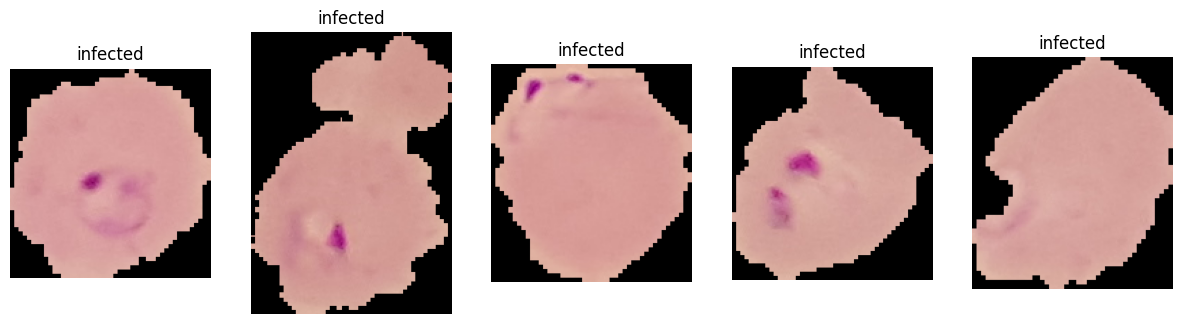

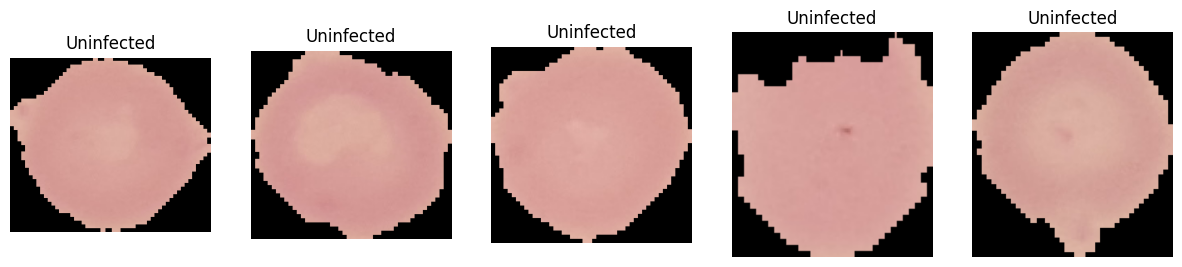

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Set the path to the dataset
dataset_path = 'D:/R001/cell_images'
infected_path = os.path.join(dataset_path, 'infected')
uninfected_path = os.path.join(dataset_path, 'uninfected')

# Display some sample images
def display_samples(category, sample_size=5):
    category_path = os.path.join(dataset_path, category)
    samples = os.listdir(category_path)[:sample_size]
    plt.figure(figsize=(15, 15))
    for i, sample in enumerate(samples):
        img = Image.open(os.path.join(category_path, sample))
        plt.subplot(1, sample_size, i + 1)
        plt.imshow(img)
        plt.title(category)
        plt.axis('off')
    plt.show()

display_samples('infected')
display_samples('Uninfected')


Data Augmentation

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.15
)


Data Spliting

In [4]:
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

test_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)


Found 23426 images belonging to 2 classes.
Found 4132 images belonging to 2 classes.
Found 4132 images belonging to 2 classes.


Step:2 Model selection

inception-v3

In [4]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)


Step:3 Training with different optimizers

In [5]:
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

batch_size = 32
epochs = 1
learning_rates = {
    'SGD': 0.001,
    'Adam': 0.001,
    'RMSprop': 0.0001
}

optimizers = {
    'SGD': SGD(learning_rate=learning_rates['SGD']),
    'Adam': Adam(learning_rate=learning_rates['Adam']),
    'RMSprop': RMSprop(learning_rate=learning_rates['RMSprop'])
}

compile and Train the model

In [6]:
histories = {}

for opt_name, optimizer in optimizers.items():
    print(f"Training with {opt_name} optimizer...")
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=validation_generator,
        verbose=1
    )
    histories[opt_name] = history
    model.save(f'inception_v3_{opt_name}.h5')


Training with SGD optimizer...


C:\Users\Hamza\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


733/733 ━━━━━━━━━━━━━━━━━━━━ 3132s 4s/step - accuracy: 0.7651 - loss: 0.5170 - val_accuracy: 0.9008 - val_loss: 0.2787


Training with Adam optimizer...
733/733 ━━━━━━━━━━━━━━━━━━━━ 3233s 4s/step - accuracy: 0.9184 - loss: 0.2655 - val_accuracy: 0.9414 - val_loss: 0.2107


Training with RMSprop optimizer...
733/733 ━━━━━━━━━━━━━━━━━━━━ 3265s 4s/step - accuracy: 0.9648 - loss: 0.1041 - val_accuracy: 0.9465 - val_loss: 0.1590


Step:4 Evaluation and comparison

Evaluate the model

In [7]:
results = {}

for opt_name in optimizers.keys():
    print(f"Evaluating {opt_name} optimizer...")
    model.load_weights(f'inception_v3_{opt_name}.h5')
    scores = model.evaluate(test_generator, verbose=1)
    results[opt_name] = {
        'Test Loss': scores[0],
        'Test Accuracy': scores[1]
    }
    print(f"{opt_name} Test Loss: {scores[0]}, Test Accuracy: {scores[1]}")


Evaluating SGD optimizer...
130/130 ━━━━━━━━━━━━━━━━━━━━ 95s 729ms/step - accuracy: 0.9000 - loss: 0.2963
SGD Test Loss: 0.28101450204849243, Test Accuracy: 0.9022265076637268
Evaluating Adam optimizer...
130/130 ━━━━━━━━━━━━━━━━━━━━ 103s 790ms/step - accuracy: 0.9441 - loss: 0.1915
Adam Test Loss: 0.19783304631710052, Test Accuracy: 0.9443368911743164
Evaluating RMSprop optimizer...
130/130 ━━━━━━━━━━━━━━━━━━━━ 101s 772ms/step - accuracy: 0.9462 - loss: 0.1664
RMSprop Test Loss: 0.15452337265014648, Test Accuracy: 0.9479671120643616


Compare the optimizers

In [19]:
import pandas as pd

comparison_df = pd.DataFrame(results).T
print(comparison_df)


         Test Loss  Test Accuracy
SGD       0.281015       0.902227
Adam      0.197833       0.944337
RMSprop   0.154523       0.947967
